# Importing Necessary Libraries

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from textblob import TextBlob
import seaborn as sns
import re
import missingno as msno 
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from collections import Counter

# Uploading the Dataset

In [2]:
#Uploading the datasets
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")
trainingSet.head()

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score
0,195370,1890228583,A3VLX5Z090RQ0V,1,2,1030838400,An Unexplained Anime Review,I was very anxious to see the Uncut version of...,2.0
1,1632470,B00BEIYSL4,AUDXDMFM49NGY,0,1,1405036800,not great.,Movie was okay...not great.,3.0
2,9771,0767809335,A3LFIA97BUU5IE,3,36,983750400,Technical problem with this DVD,"Like the Dinosaur Collector's Edition DVD, thi...",1.0
3,218855,6300215792,A1QZM75342ZQVQ,1,1,1394841600,Heeeeyyyyy LAAAAADEEE!!!!,"Come on, now..... this has to be, by far, the...",5.0
4,936225,B000B5XOZW,ANM2SCEUL3WL1,1,1,1163721600,Herzog the Great Traveler of both natural and ...,I've always been a great admirer of Herzog's o...,4.0


In [3]:
print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

train.csv shape is  (139753, 9)
test.csv shape is  (17470, 2)


In [4]:
#Check for missing values
trainingSet.isnull().sum()

Id                            0
ProductId                     0
UserId                        0
HelpfulnessNumerator          0
HelpfulnessDenominator        0
Time                          0
Summary                       1
Text                          1
Score                     17470
dtype: int64

In [5]:
#Check for duplicate rows
trainingSet.duplicated().sum()

0

# Feature Extractions for Plotting

In [6]:
trainingSet['HelpfulnessRatio'] = np.where(
    trainingSet['HelpfulnessDenominator'] > 0,
    trainingSet['HelpfulnessNumerator'] /
    trainingSet['HelpfulnessDenominator'], -1)

trainingSet['NotHelpful'] = trainingSet[
    'HelpfulnessDenominator'] - trainingSet['HelpfulnessNumerator']

In [7]:
trainingSet['Time'] = pd.to_datetime(trainingSet['Time'], unit='s')
trainingSet['Year'] = trainingSet['Time'].dt.year
trainingSet['Month'] = trainingSet['Time'].dt.month
trainingSet['Day'] = trainingSet['Time'].dt.day
trainingSet['DayOfWeek'] = trainingSet['Time'].dt.dayofweek

In [8]:
trainingSet['Text'].fillna('', inplace=True)
trainingSet['Summary'].fillna('', inplace=True)
trainingSet["Review"] = trainingSet["Summary"] + " " + trainingSet["Text"]
trainingSet['Review'].fillna('', inplace=True)
trainingSet['ReviewLength'] = trainingSet.apply(lambda row : len(row['Review'].split()) if type(row['Review']) == str else 0, axis = 1)

In [9]:
trainingSet['UserAverageReviewLength'] = trainingSet.groupby('UserId')['ReviewLength'].transform('mean')
trainingSet['ProductReviewVolume'] = trainingSet.groupby('ProductId')['Id'].transform('count')
trainingSet['UserReviewCount'] = trainingSet.groupby('UserId')['Id'].transform('count')
product_first_review_time = trainingSet.groupby('ProductId')['Time'].transform('min')
trainingSet['TimeSinceFirstReview'] = (trainingSet['Time'] - product_first_review_time).dt.days
trainingSet['RepeatPurchases'] = trainingSet.groupby(['ProductId', 'UserId']).cumcount() + 1
trainingSet['RepeatPurchases'] = (trainingSet['RepeatPurchases'] > 1).astype(int)

In [10]:
trainingSet['ReviewPolarity'] = trainingSet['Review'].apply(lambda text: TextBlob(text).sentiment.polarity)
trainingSet['ReviewSubjectivity'] = trainingSet['Review'].apply(lambda text: TextBlob(text).sentiment.subjectivity) 

In [39]:
good_words_full = ['great', 'like', 'good', 'love', 'best', 'really', 'enjoyed', 'fantastic', 'amazing', 'excellent', 'wonderful']
trainingSet['GoodWordsRatio'] = trainingSet['Review'].apply(lambda review: sum(review.lower().count(word) for word in good_words_full) / len(review.split()) if len(review.split()) > 0 else 0)
    
bad_words_full = ['even', 'bad', 'worst', 'awful', 'terrible', 'horrible', 'disappointing', 'disappointed', 'poor', 'hate']
trainingSet['BadWordsRatio'] = trainingSet['Review'].apply(lambda review: sum(review.lower().count(word) for word in bad_words_full) / len(review.split()) if len(review.split()) > 0 else 0)

# Analyzing Features

## Understanding the Dataset

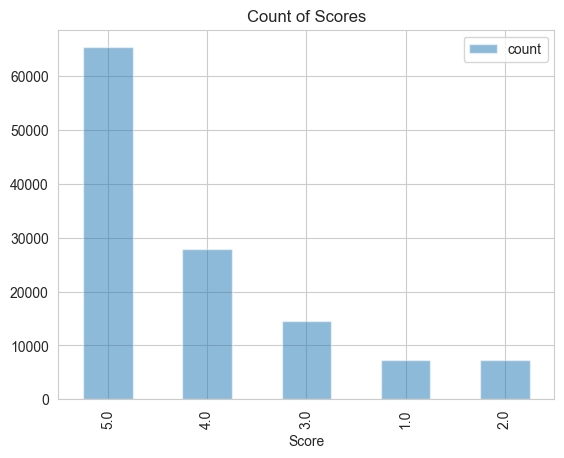

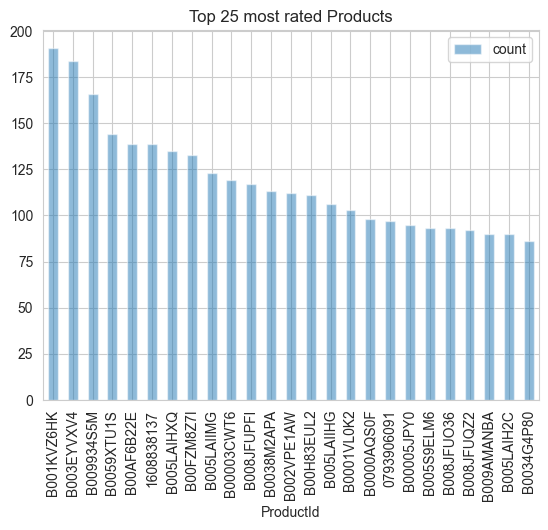

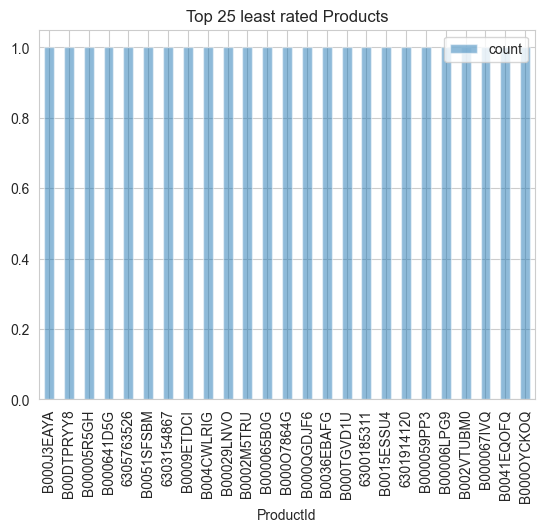

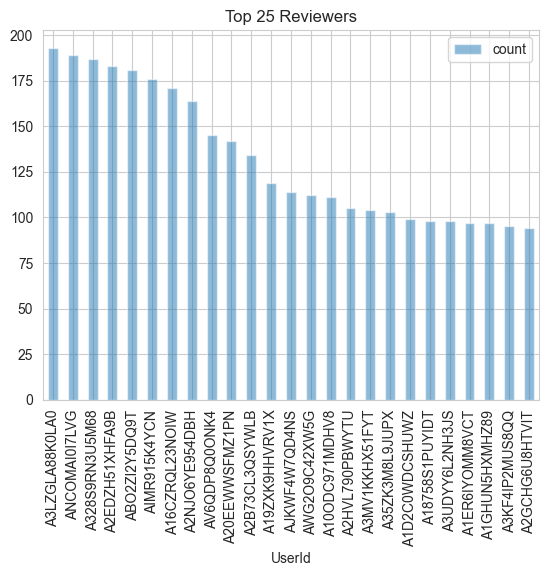

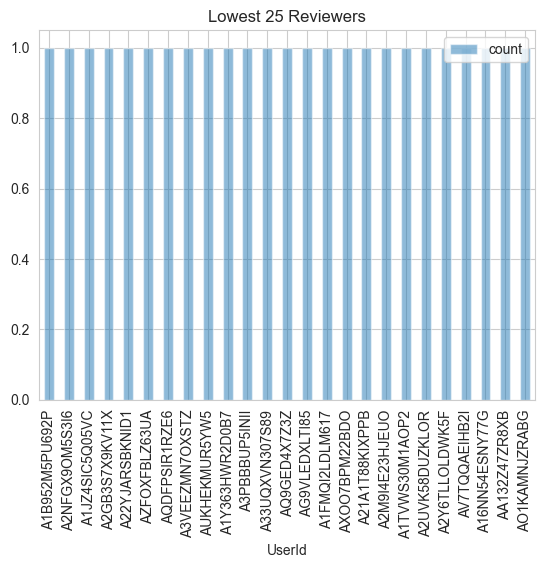

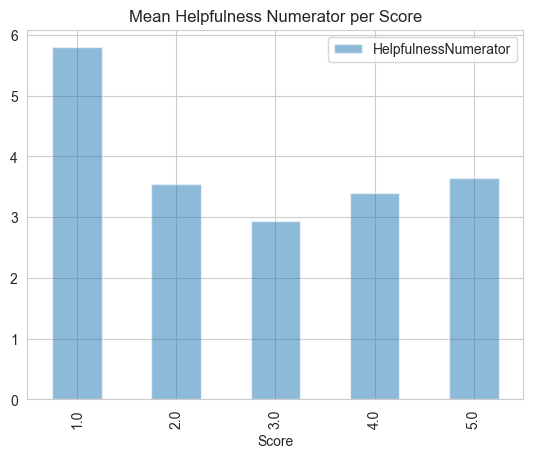

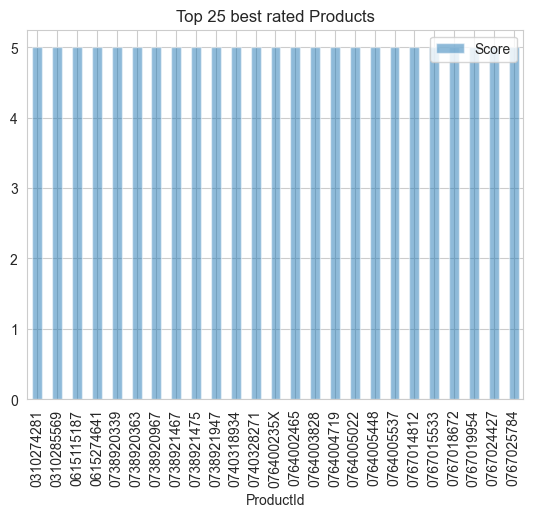

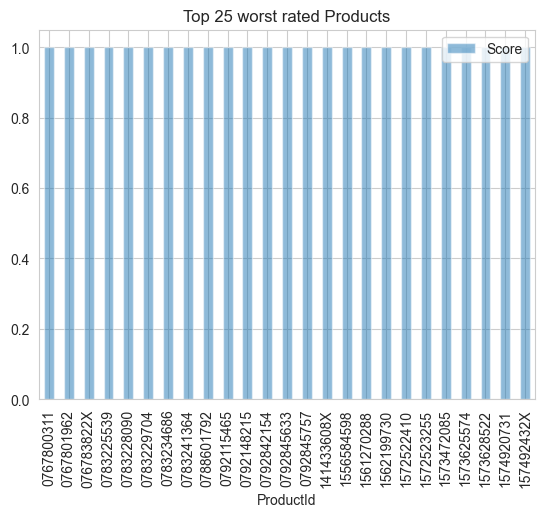

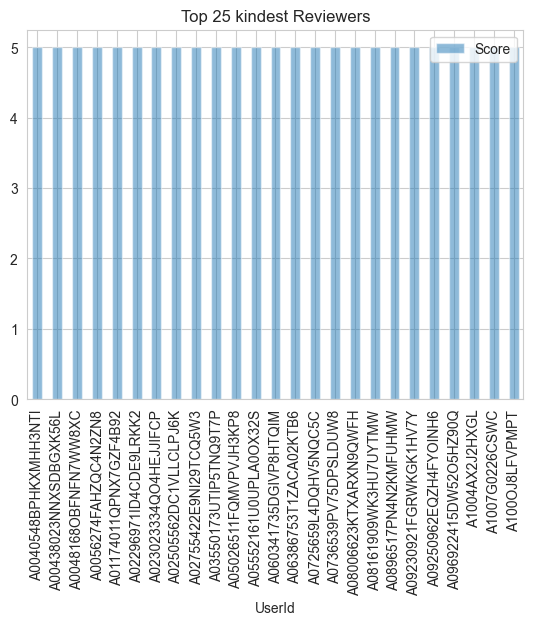

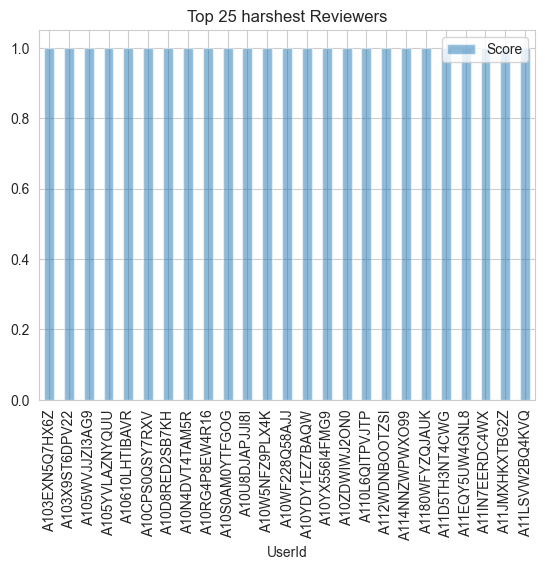

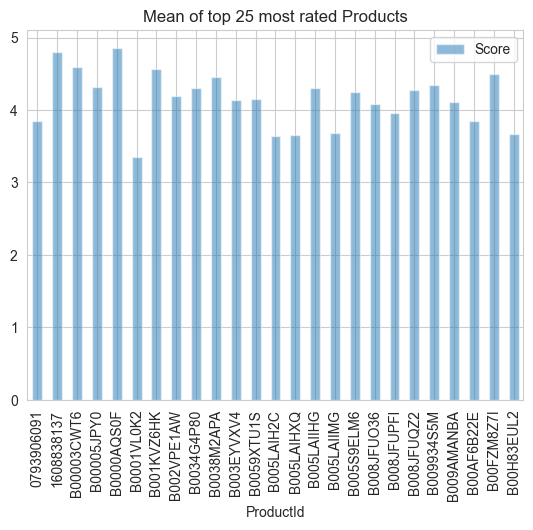

In [42]:
trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.title("Count of Scores")
plt.show()

trainingSet['ProductId'].value_counts().nlargest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 most rated Products")
plt.show()

trainingSet['ProductId'].value_counts().nsmallest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 least rated Products")
plt.show()

trainingSet['UserId'].value_counts().nlargest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 Reviewers")
plt.show()

trainingSet['UserId'].value_counts().nsmallest(25).plot(kind='bar', legend=True, alpha=.5)
plt.title("Lowest 25 Reviewers")
plt.show()

trainingSet[['Score', 'HelpfulnessNumerator']].groupby('Score').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title("Mean Helpfulness Numerator per Score")
plt.show()

trainingSet[['Score', 'ProductId']].groupby('ProductId').mean().nlargest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 best rated Products")
plt.show()

trainingSet[['Score', 'ProductId']].groupby('ProductId').mean().nsmallest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 worst rated Products")
plt.show()

trainingSet[['Score', 'UserId']].groupby('UserId').mean().nlargest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 kindest Reviewers")
plt.show()

trainingSet[['Score', 'UserId']].groupby('UserId').mean().nsmallest(25, 'Score').plot(kind='bar', legend=True, alpha=.5)
plt.title("Top 25 harshest Reviewers")
plt.show()

trainingSet[trainingSet['ProductId'].isin(trainingSet['ProductId'].value_counts().nlargest(25).index.tolist())][['Score', 'ProductId']].groupby('ProductId').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title("Mean of top 25 most rated Products")
plt.show()

#### Looking at the occurence of each score, we can clearly see that 5 is dominating rest of the scores.

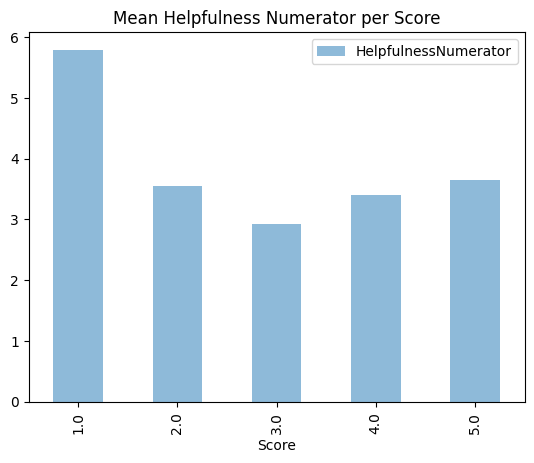

In [12]:
trainingSet[['Score', 'HelpfulnessNumerator']].groupby('Score').mean().plot(kind='bar', legend=True, alpha=.5)
plt.title("Mean Helpfulness Numerator per Score")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: Futur

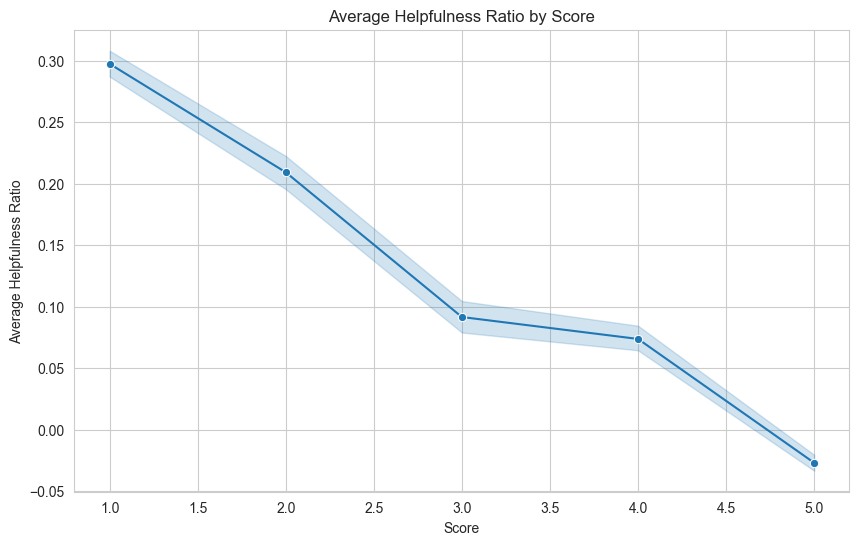

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: Futur

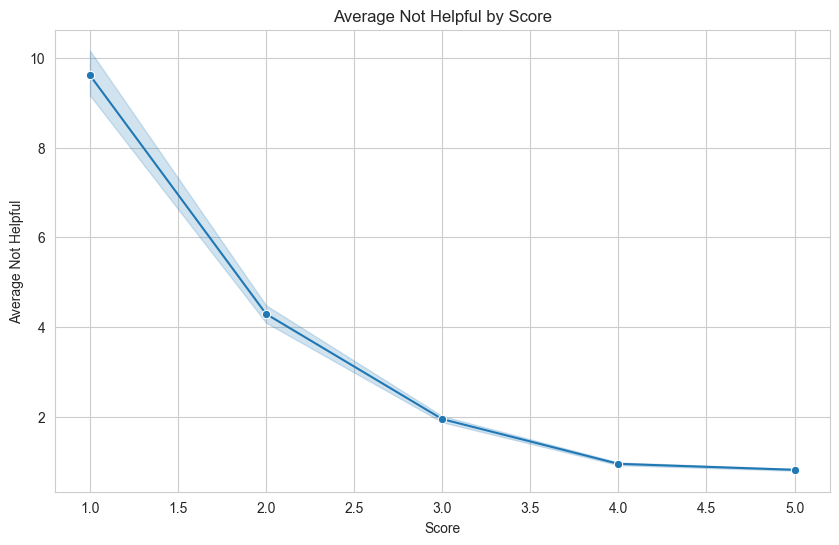

In [44]:

# Plot HelpfulnessRatio vs Score
plt.figure(figsize=(10, 6))
sns.lineplot(data=trainingSet, x='Score', y='HelpfulnessRatio', marker='o')
plt.title('Average Helpfulness Ratio by Score')
plt.xlabel('Score')
plt.ylabel('Average Helpfulness Ratio')
plt.show()

# Plot NotHelpful vs Score
plt.figure(figsize=(10, 6))
sns.lineplot(data=trainingSet, x='Score', y='NotHelpful', marker='o')
plt.title('Average Not Helpful by Score')
plt.xlabel('Score')
plt.ylabel('Average Not Helpful')
plt.show()

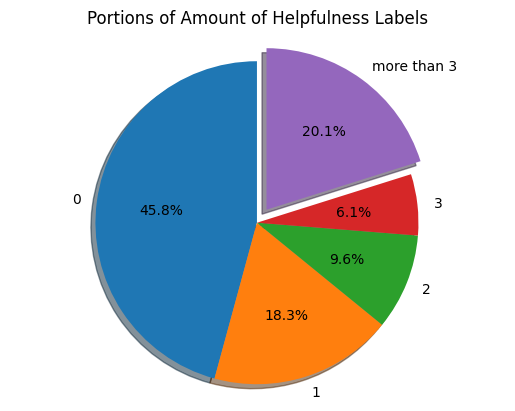

In [27]:
# Count the occurrences for each value range
value_counts = trainingSet['HelpfulnessNumerator'].value_counts().sort_index()
helpfulness_categories = {
    '0': value_counts.get(0, 0),
    '1': value_counts.get(1, 0),
    '2': value_counts.get(2, 0),
    '3': value_counts.get(3, 0),
    'more than 3': value_counts.loc[4:].sum() if 4 in value_counts else 0
}

# Prepare labels and sizes for the pie chart
labels = list(helpfulness_categories.keys())
sizes = list(helpfulness_categories.values())
explode = (0, 0, 0, 0, 0.1)  # "Explode" the last slice for emphasis

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Portions of Amount of Helpfulness Labels')
plt.show()

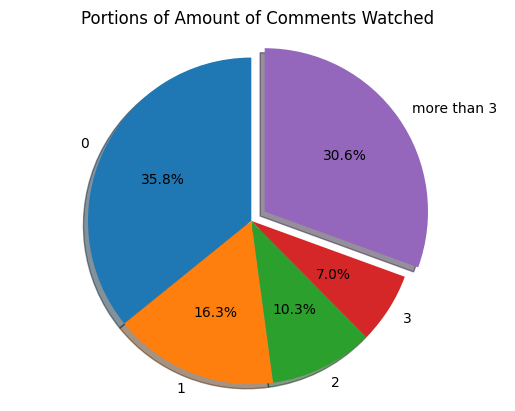

In [28]:
value_counts = trainingSet['HelpfulnessDenominator'].value_counts().sort_index()
helpfulness_categories = {
    '0': value_counts.get(0, 0),
    '1': value_counts.get(1, 0),
    '2': value_counts.get(2, 0),
    '3': value_counts.get(3, 0),
    'more than 3': value_counts.loc[4:].sum() if 4 in value_counts else 0
}

# Prepare labels and sizes for the pie chart
labels = list(helpfulness_categories.keys())
sizes = list(helpfulness_categories.values())
explode = (0, 0, 0, 0, 0.1)  # "Explode" the last slice (more than 3) for emphasis

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Portions of Amount of Comments Watched')
plt.show()

[nltk_data] Downloading package stopwords to /Users/doruk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


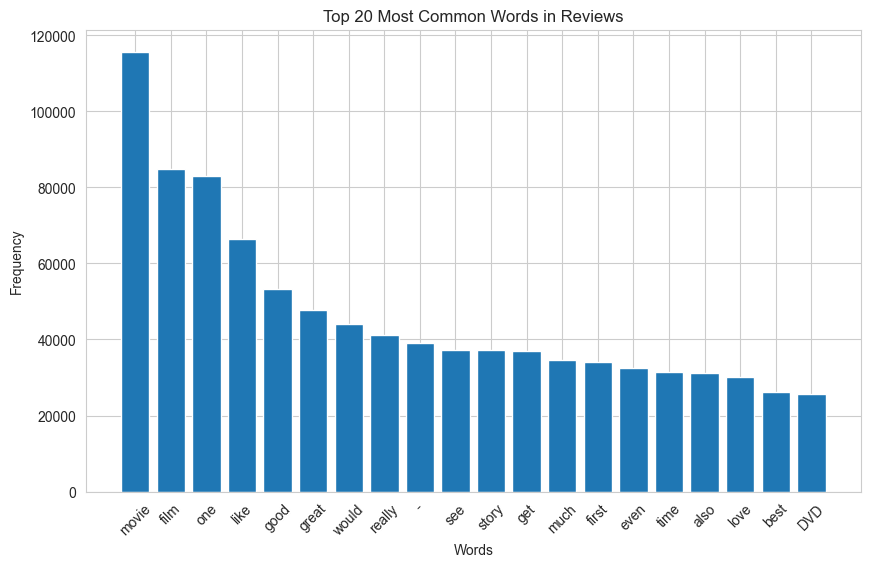

In [55]:
nltk.download('stopwords')
# Combine all reviews into one large text
text = ' '.join(review for review in trainingSet['Review'] if isinstance(review, str))

# Tokenize the text into words
words = text.split()

# Optionally, remove common words that don't carry much meaning
stop_words = set(stopwords.words('english'))
words = [word for word in words if word.lower() not in stop_words]

# Count the frequency of each word
word_counts = Counter(words)

# Get the most common words
most_common_words = word_counts.most_common(20)

# Prepare data for plotting
words, counts = zip(*most_common_words)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(words, counts)
plt.title('Top 20 Most Common Words in Reviews')
plt.xticks(rotation=45)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

/var/folders/wb/xzynz9w52kgcmqngk1sh79p40000gn/T/ipykernel_1773/1430631818.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Score', y='GoodWordsRatio', data=trainingSet, ci=None)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be 

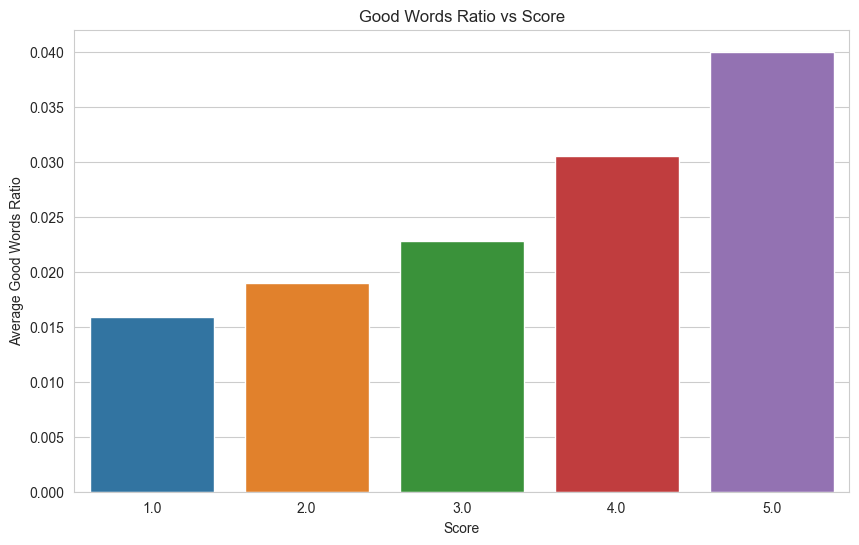

In [56]:
# Plot GoodWordsRatio vs Score
plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='GoodWordsRatio', data=trainingSet, ci=None)
plt.title('Good Words Ratio vs Score')
plt.ylabel('Average Good Words Ratio')
plt.xlabel('Score')
plt.show()

/var/folders/wb/xzynz9w52kgcmqngk1sh79p40000gn/T/ipykernel_1773/1534718283.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Score', y='BadWordsRatio', data=trainingSet, ci=None)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

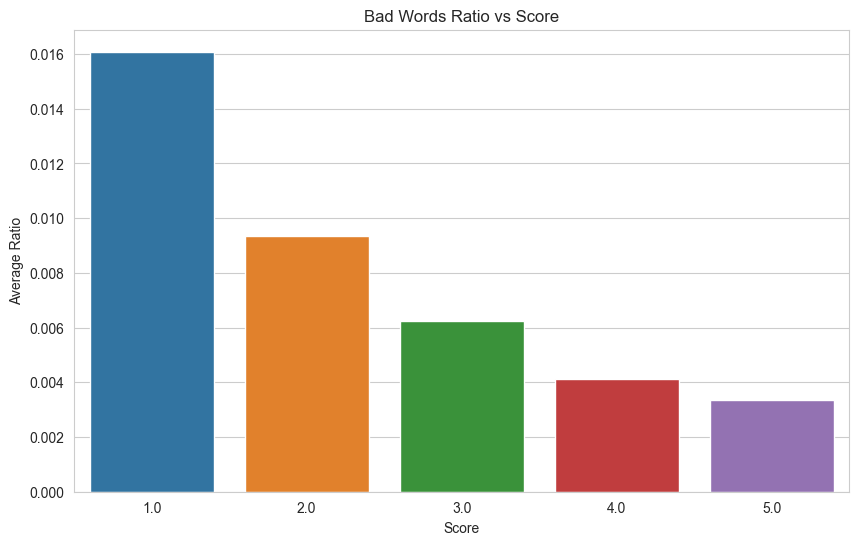

In [57]:
# Plot BadWordsRatio vs Score
plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='BadWordsRatio', data=trainingSet, ci=None)
plt.title('Bad Words Ratio vs Score')
plt.ylabel('Average Ratio')
plt.xlabel('Score')
plt.show()

## Analyzing User and Product based features

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


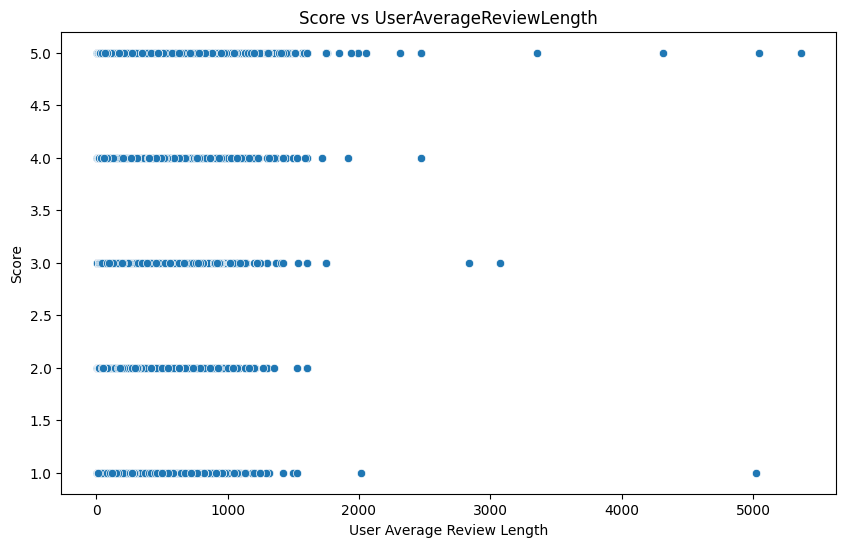

In [31]:
# Plot Score vs UserAverageReviewLength
plt.figure(figsize=(10, 6))
sns.scatterplot(data=trainingSet, x='UserAverageReviewLength', y='Score')
plt.title('Score vs UserAverageReviewLength')
plt.xlabel('User Average Review Length')
plt.ylabel('Score')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


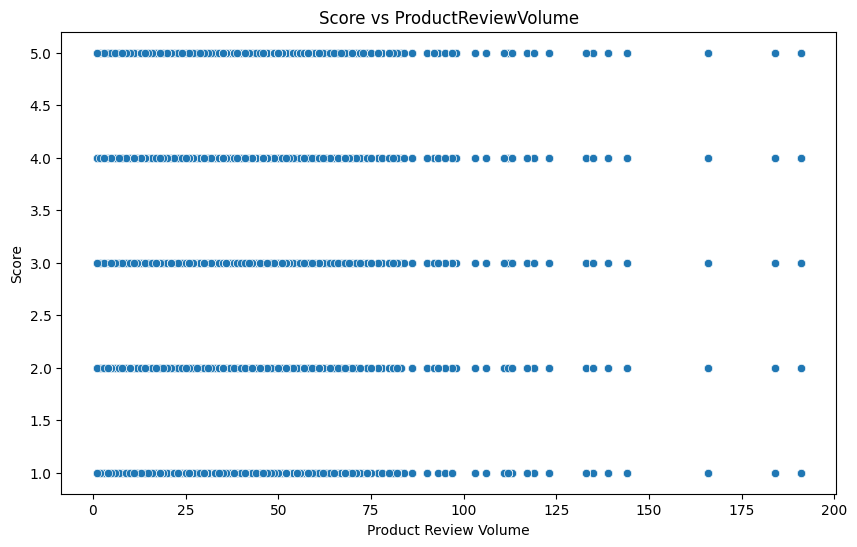

In [32]:
# Next, we'll create and plot the ProductReviewVolume column
plt.figure(figsize=(10, 6))
sns.scatterplot(data=trainingSet, x='ProductReviewVolume', y='Score')
plt.title('Score vs ProductReviewVolume')
plt.xlabel('Product Review Volume')
plt.ylabel('Score')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


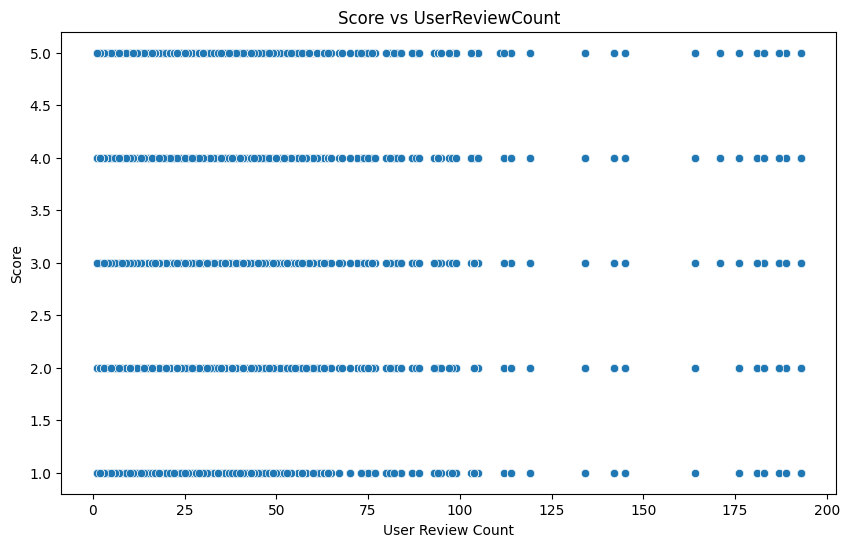

In [33]:
# Next, we'll create and plot the UserReviewCount column
plt.figure(figsize=(10, 6))
sns.scatterplot(data=trainingSet, x='UserReviewCount', y='Score')
plt.title('Score vs UserReviewCount')
plt.xlabel('User Review Count')
plt.ylabel('Score')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


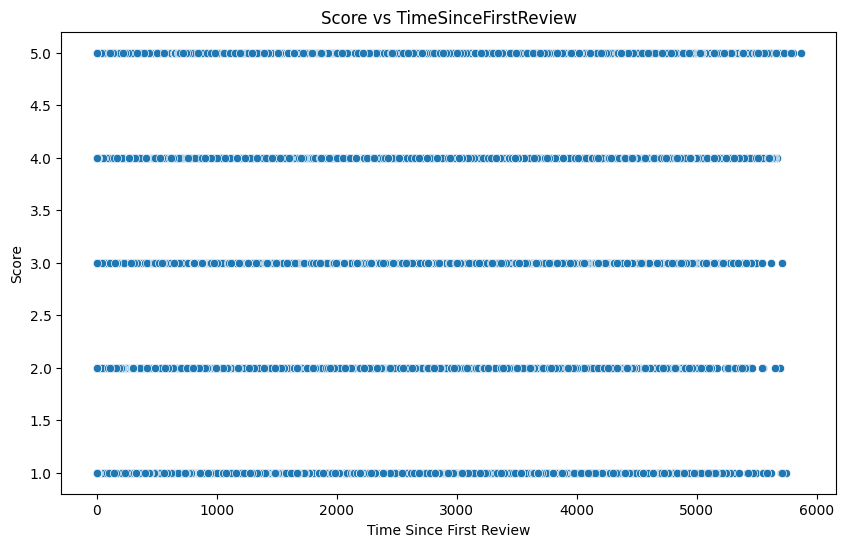

In [34]:
# Next, we'll create and plot the TimeSinceFirstReview column
plt.figure(figsize=(10, 6))
sns.scatterplot(data=trainingSet, x='TimeSinceFirstReview', y='Score')
plt.title('Score vs TimeSinceFirstReview')
plt.xlabel('Time Since First Review')
plt.ylabel('Score')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


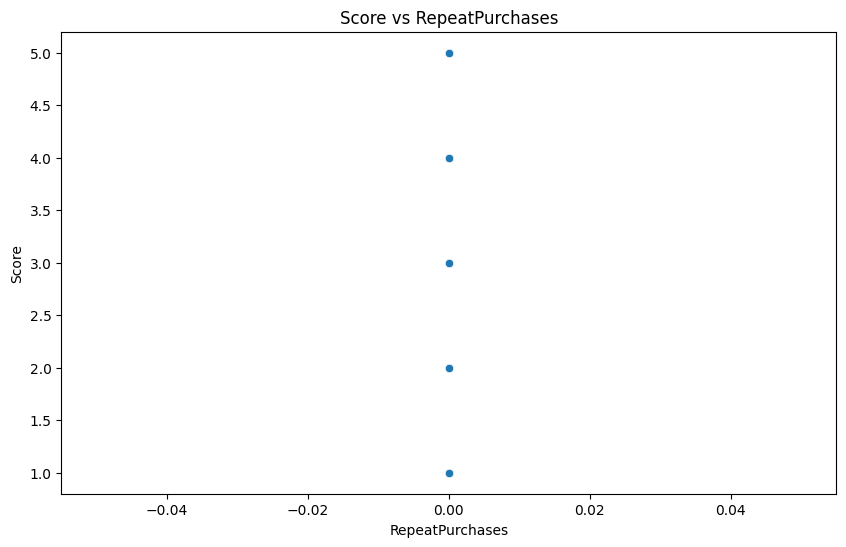

In [35]:
# Finally, we'll create and plot the RepeatPurchases column
plt.figure(figsize=(10,6))
sns.scatterplot(data=trainingSet, x='RepeatPurchases', y='Score')
plt.title('Score vs RepeatPurchases')
plt.xlabel('RepeatPurchases')
plt.ylabel('Score')
plt.show()

In [36]:
correlations = trainingSet[['Score', 'UserAverageReviewLength', 'ProductReviewVolume', 'UserReviewCount', 
                   'TimeSinceFirstReview', 'RepeatPurchases']].corr()

# Isolating the correlation coefficients with the Score
score_correlations = correlations['Score'].sort_values(ascending=False)
score_correlations

Score                      1.000000
TimeSinceFirstReview       0.119011
ProductReviewVolume        0.014023
UserReviewCount           -0.066537
UserAverageReviewLength   -0.104264
RepeatPurchases                 NaN
Name: Score, dtype: float64

<Axes: >

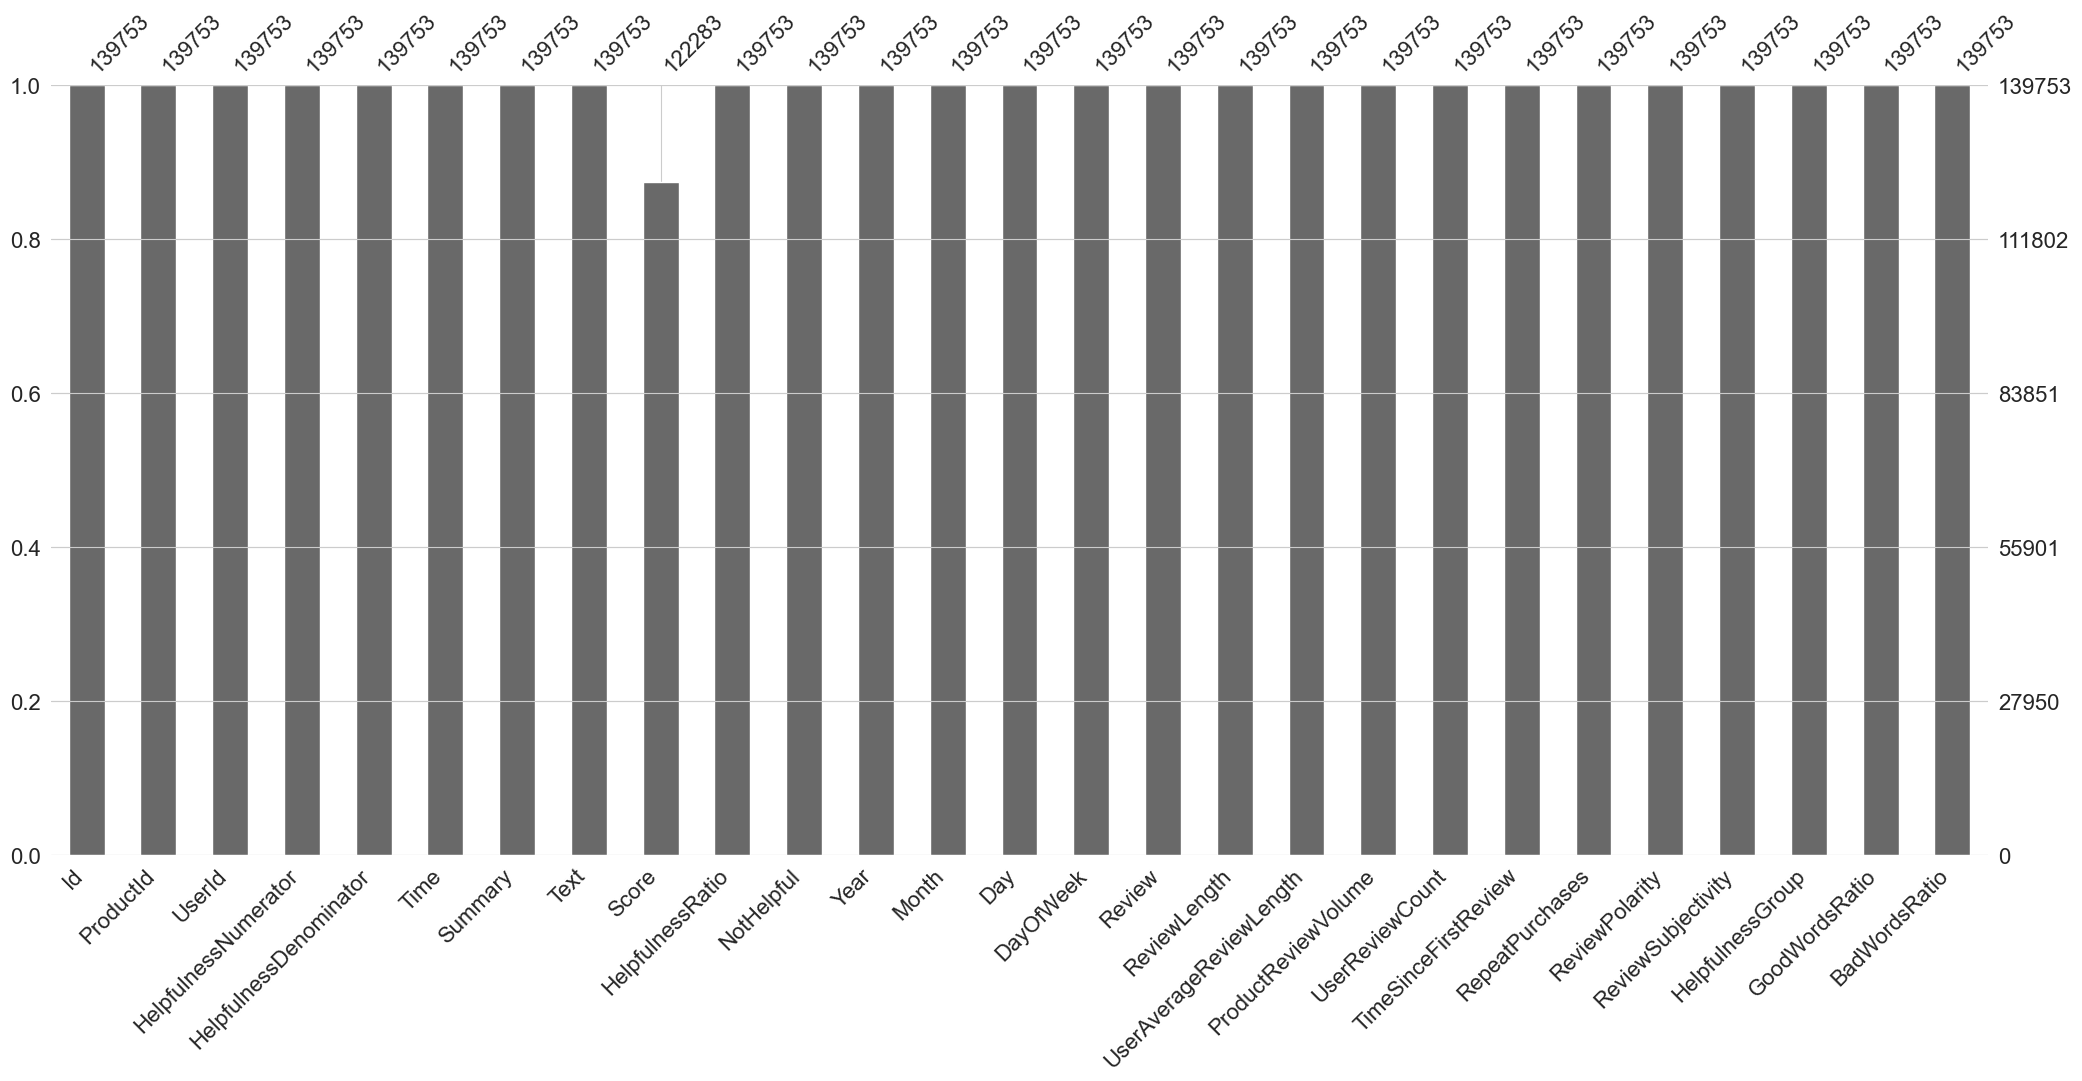

In [48]:
#Checking for missing values
msno.bar(trainingSet)

### Only the score column has some missing values the rest of the data does NOT contain missing values that might damage our accuracy.

## Sentiment Based Feature Analysis

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: Futur

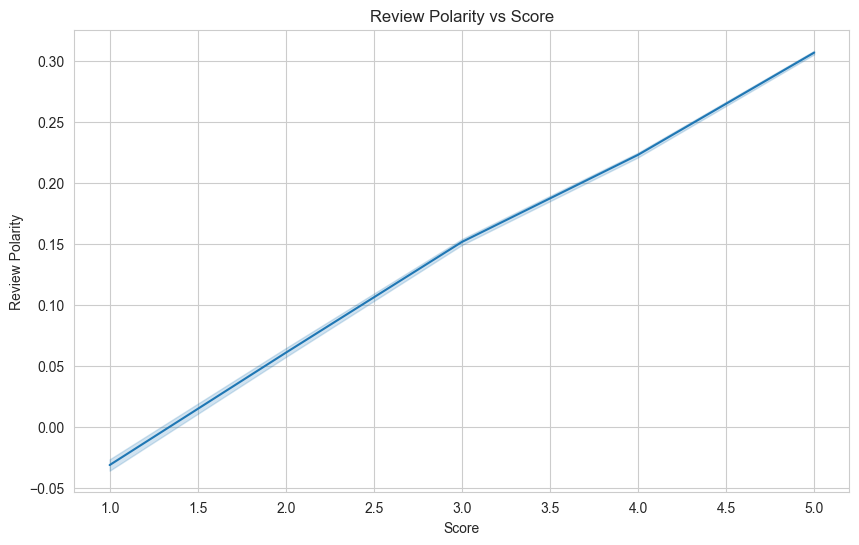

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: Futur

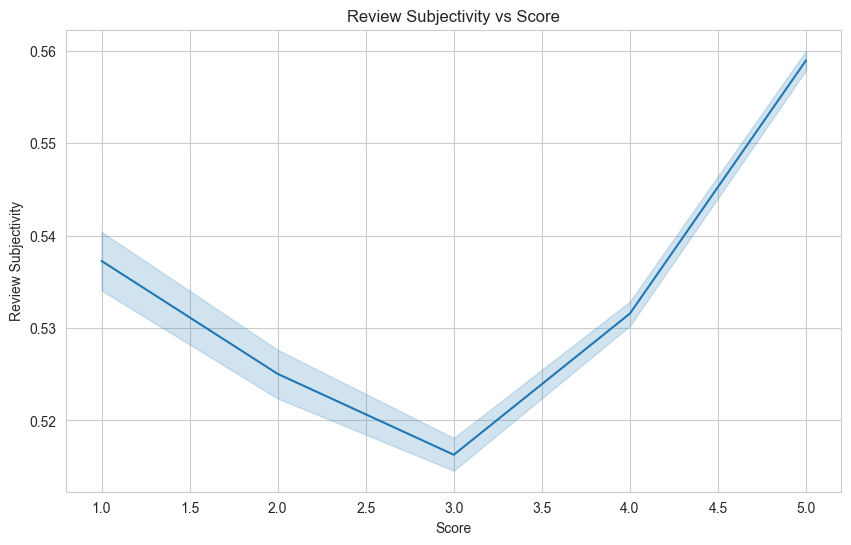

In [58]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot ReviewPolarity vs Score
plt.figure(figsize=(10, 6))
sns.lineplot(data=trainingSet, x='Score', y='ReviewPolarity')
plt.title('Review Polarity vs Score')
plt.xlabel('Score')
plt.ylabel('Review Polarity')
plt.show()

# Plot ReviewSubjectivity vs Score
plt.figure(figsize=(10, 6))
sns.lineplot(data=trainingSet, x='Score', y='ReviewSubjectivity')
plt.title('Review Subjectivity vs Score')
plt.xlabel('Score')
plt.ylabel('Review Subjectivity')
plt.show()